In [1]:
from transformers import AutoTokenizer
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## Loading

In [2]:
# Load Tokenizers
with open("user_config.json", "r") as f:
    config = json.load(f)

token_1 = config["huggingface_token"]['token_1'] # from the main acoount
token_2 = config["huggingface_token"]['token_2'] # from the sub account

tokenizer_configs = {
    "google/gemma-2-2b-it": token_1,
    "google/gemma-2-9b-it": token_1,
    "google/gemma-3-12b-it": token_1,
    "meta-llama/Llama-3.2-1B-Instruct": token_2,
    "meta-llama/Llama-3.2-3B-Instruct": token_2,
    "meta-llama/Llama-3.1-8B-Instruct": token_2,
    "microsoft/phi-4": None,
    "microsoft/Phi-4-mini-instruct": None,
    "microsoft/Phi-3-small-8k-instruct": None,
    "microsoft/Phi-3-mini-4k-instruct": None,
    "microsoft/Phi-3.5-mini-instruct": None,
    "bigscience/bloom-7b1": None,
    "Tower-Babel/Babel-9B-Chat": None
}

In [3]:
# Load Testsets
seed = 2025
n_sample = 100

languages = {"eng_Latn": "English", "kor_Hang": "Korean", "deu_Latn": "German"}
samples = {}

for lang_code, lang_name in languages.items():
    dataset = load_dataset("facebook/flores", lang_code, trust_remote_code=True)
    samples[lang_name] = dataset["dev"].shuffle(seed=seed).select(range(n_sample))["sentence"]
    
df = pd.DataFrame()
for lang_name, sample_data in samples.items():
    df[lang_name] = [s for s in sample_data]


In [27]:
# Load DownStream Performance Results - MMLU-Pro & FLORES

html_file_path = '/home/hyujang/multilingual-inner-lexicon/data/results.html'
tables = pd.read_html(html_file_path)
df_results = tables[0]
df_results = df_results.rename(columns={"Unnamed: 0": "Benchmark"})

tokenizer_mmlupro = df_results.iloc[41,1:].to_dict() # https://huggingface.co/spaces/open-llm-leaderboard/comparator
del(df_results)

tokenizer_configs.keys() - tokenizer_mmlupro.keys()
tokenizer_mmlupro['google/gemma-3-12b-it'] = 0.606 # https://huggingface.co/spaces/TIGER-Lab/MMLU-Pro
tokenizer_mmlupro['Tower-Babel/Babel-9B-Chat'] = 0 # No information available

tokenizer_flores = {
    "google/gemma-2-2b-it": 0,
    "google/gemma-2-9b-it": 0.548,
    "google/gemma-3-12b-it": 0,
    "meta-llama/Llama-3.2-1B-Instruct": 0,
    "meta-llama/Llama-3.2-3B-Instruct": 0,
    "meta-llama/Llama-3.1-8B-Instruct": 0.473,
    "microsoft/phi-4": 0,
    "microsoft/Phi-4-mini-instruct": 0,
    "microsoft/Phi-3-small-8k-instruct": 0,
    "microsoft/Phi-3-mini-4k-instruct": 0,
    "microsoft/Phi-3.5-mini-instruct": 0,
    "bigscience/bloom-7b1": 0,
    "Tower-Babel/Babel-9B-Chat": 0.567
}

## Preprocessing

In [7]:
# SENTENCE -> WORD

### English
import nltk
import nltk.data
from nltk.tokenize import word_tokenize
# nltk.download('punkt_tab', download_dir='/work/hyujang/miniconda3/envs/thesis/nltk_data')
# nltk.download('punkt', download_dir='/work/hyujang/miniconda3/envs/thesis/nltk_data')
# nltk.data.path.append('/work/hyujang/miniconda3/envs/thesis/nltk_data')
df['English_nltk'] = df['English'].apply(lambda x: word_tokenize(x, language='english'))
# import spacy
# nlp = spacy.load('en_core_web_sm')
# df['English_spacy'] = df['English'].apply(lambda text: [token.text for token in nlp(text)])

### Korean
# from kiwipiepy import Kiwi
# kiwi = Kiwi()
# df['Korean_kiwi'] = df['Korean'].apply(lambda x: [token[0] for token in kiwi.tokenize(x)])
from konlpy.tag import Okt # TODO: Mecab
okt = Okt()
df['Korean_okt'] = df['Korean'].apply(lambda x: okt.morphs(x))

### German
df['German_nltk'] = df['German'].apply(lambda x: word_tokenize(x, language='german'))

lang_wordinzer = {"English": "nltk", "Korean": "okt", "German": "nltk"}

In [8]:
def calculate_subword_fertility(tokens, tokenizer):
    subword_lengths = [len(tokenizer.tokenize(token)) for token in tokens]
    return np.mean(subword_lengths)

for tokenizer_name, token in tokenizer_configs.items():
    try:
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=True, token=token, trust_remote_code=True)
        print(f"Loaded {tokenizer_name}")
        for lang_name in languages.values():
            df[f"{tokenizer_name}_{lang_name}_tokens"] = df[lang_name].apply(lambda x: tokenizer.tokenize(x)) 
            # df[f"{tokenizer_name}_{lang_name}_token_length"] = df[f"{tokenizer_name}_{lang_name}_tokens"].apply(len)
            df[f"{tokenizer_name}_{lang_name}_fertility"] = df[f"{lang_name}_{lang_wordinzer[lang_name]}"].apply(lambda x: calculate_subword_fertility(x, tokenizer))
    except Exception as e:
        print(f"Failed to load tokenizer {tokenizer_name}: {e}")

df.to_csv("./output/tokenizers_comparison.csv", index=False)

Loaded google/gemma-2-2b-it
Loaded google/gemma-2-9b-it
Loaded google/gemma-3-12b-it
Loaded meta-llama/Llama-3.2-1B-Instruct
Loaded meta-llama/Llama-3.2-3B-Instruct
Loaded meta-llama/Llama-3.1-8B-Instruct
Loaded microsoft/phi-4
Loaded microsoft/Phi-4-mini-instruct
Loaded microsoft/Phi-3-small-8k-instruct
Loaded microsoft/Phi-3-mini-4k-instruct
Loaded microsoft/Phi-3.5-mini-instruct
Loaded bigscience/bloom-7b1
Loaded Tower-Babel/Babel-9B-Chat


## Plotting

Saved: output/image/token_length_English.png


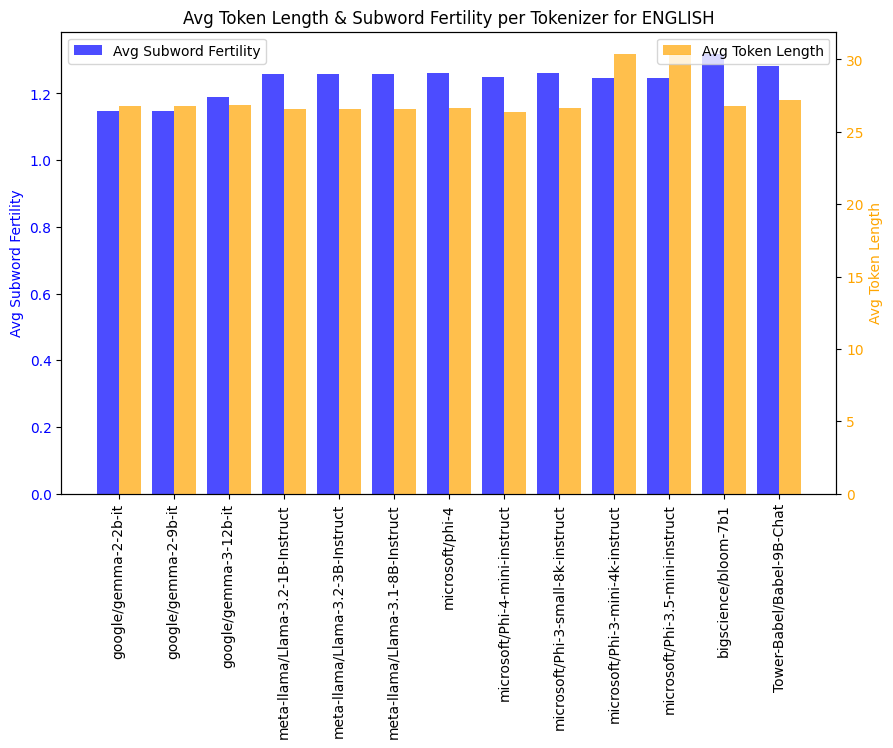

Saved: output/image/token_length_Korean.png


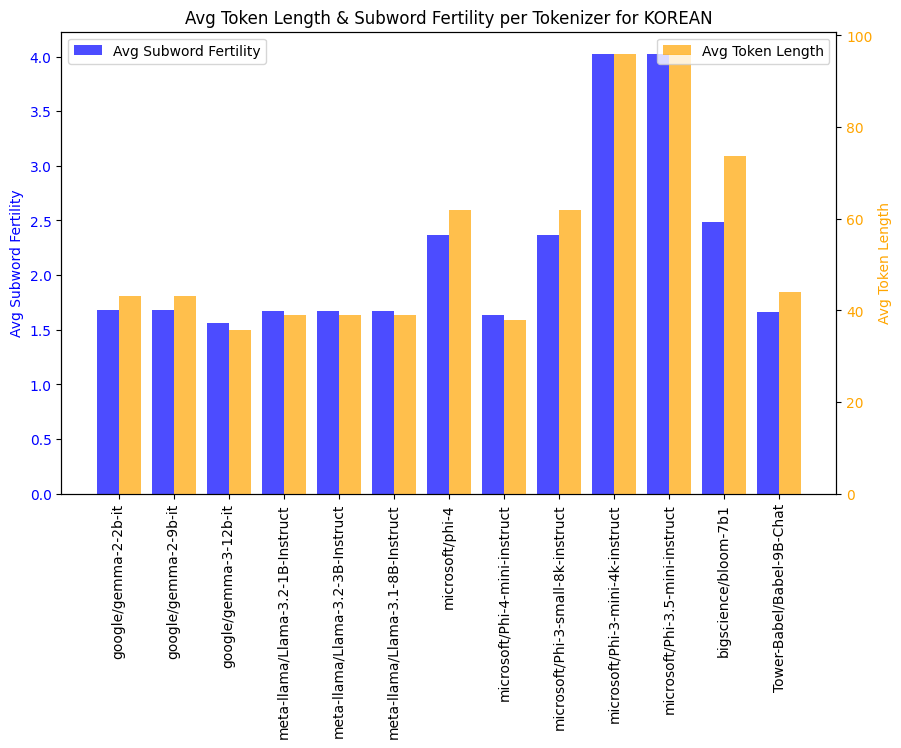

Saved: output/image/token_length_German.png


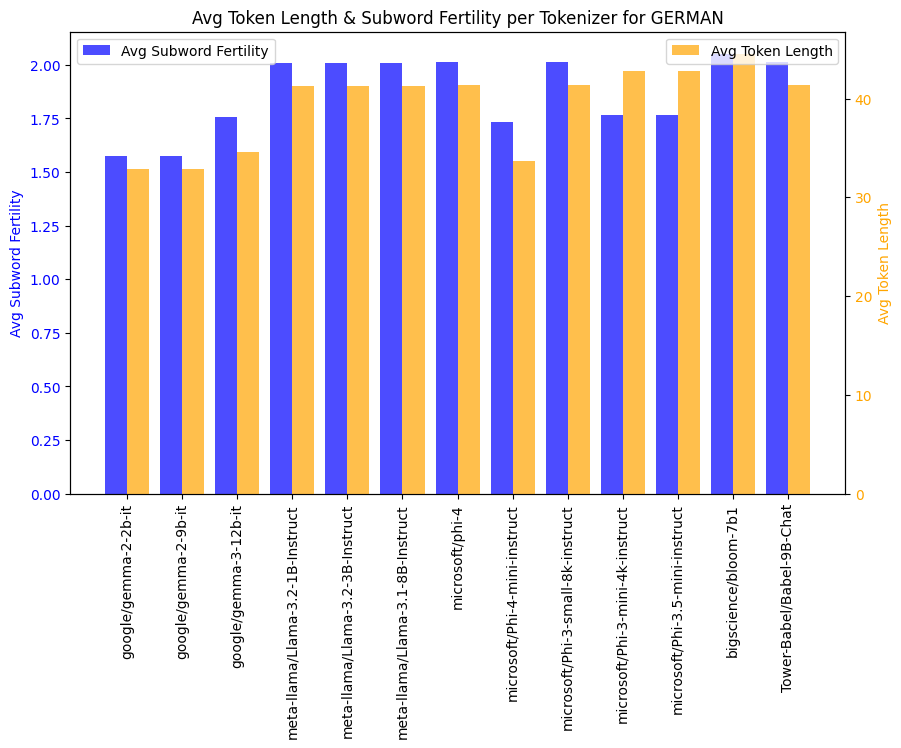

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

save = True

for lang in languages.values():
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Extract average token lengths and subword fertility for each tokenizer
    avg_lengths = {
        tokenizer_name: df[f"{tokenizer_name}_{lang}_tokens"].apply(len).mean()
        for tokenizer_name in tokenizer_configs.keys()
    }

    avg_fertility = {
        tokenizer_name: df[f"{tokenizer_name}_{lang}_fertility"].mean()
        for tokenizer_name in tokenizer_configs.keys()
    }

    tokenizer_names = list(tokenizer_configs.keys())
    x = np.arange(len(tokenizer_names))  # Position for bars

    # Bar width (ensures bars don't overlap)
    bar_width = 0.4  

    # Plot Avg Token Length on primary y-axis
    sorted_avg_lengths = [avg_lengths[tok] for tok in tokenizer_configs.keys()]
    sorted_avg_fertility = [avg_fertility[tok] for tok in tokenizer_configs.keys()]
    sorted_mmlupro = [tokenizer_mmlupro[tok] for tok in tokenizer_configs.keys()]

    ax1.bar(x - bar_width/2, avg_fertility.values(), width=bar_width, color="blue", label="Avg Subword Fertility", alpha=0.7)
    ax1.set_ylabel("Avg Subword Fertility", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax1.set_xticks(x)
    ax1.set_xticklabels(tokenizer_names, rotation=90)

    # Create Secondary Y-Axis
    ax2 = ax1.twinx()
    # ax2.bar(x + bar_width/2, sorted_mmlupro, width=bar_width, color="orange", label="MMLU Score", alpha=0.7)
    # ax2.set_ylabel("MMLU", color="orange")
    ax2.bar(x + bar_width/2, avg_lengths.values(), width=bar_width, color="orange", label="Avg Token Length", alpha=0.7)
    ax2.set_ylabel("Avg Token Length", color="orange")
    ax2.tick_params(axis='y', labelcolor="orange")

    # Title and Legend
    plt.title(f"Avg Token Length & Subword Fertility per Tokenizer for {lang.upper()}")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    if save:
        save_path = os.path.join("output/image", f"token_length_{lang}.png")
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Saved: {save_path}")

    plt.show()



Saved: output/image/mmlu_flores_score_comparison.png


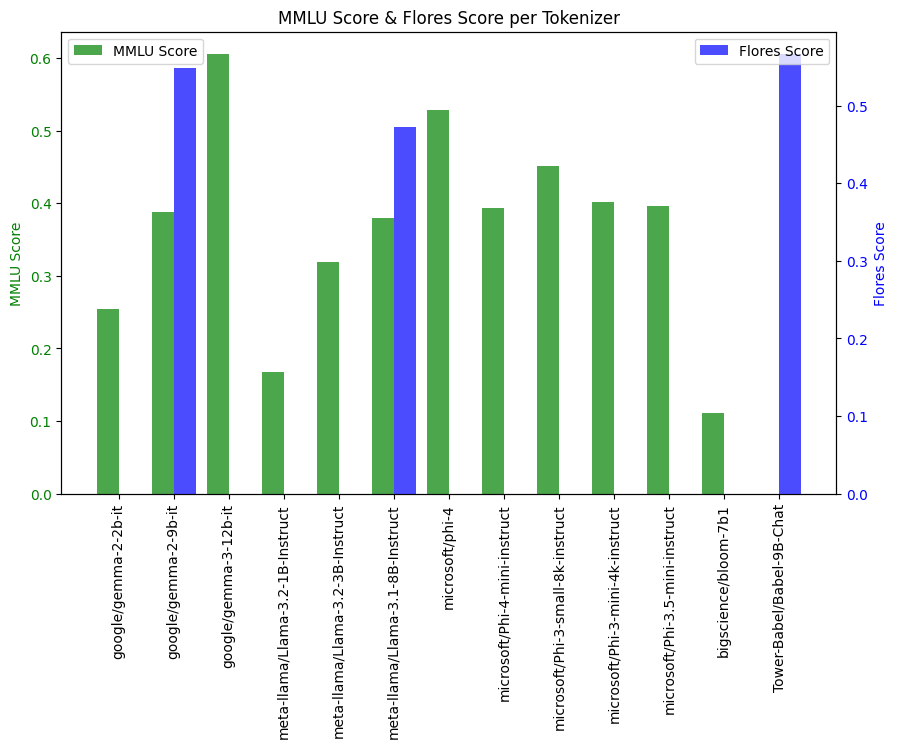

In [ ]:
sorted_mmlupro = [tokenizer_mmlupro[tok] for tok in tokenizer_configs.keys()]
sorted_flores = [tokenizer_flores[tok] for tok in tokenizer_configs.keys()]

tokenizer_names = list(tokenizer_configs.keys())
x = np.arange(len(tokenizer_names))  # Position for bars

# Bar width (ensures bars don't overlap)
bar_width = 0.4  

# Create the bar plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot MMLU Score on primary y-axis
ax1.bar(x - bar_width/2, sorted_mmlupro, width=bar_width, color="green", label="MMLU Score", alpha=0.7)
ax1.set_ylabel("MMLU Score", color="green")
ax1.tick_params(axis='y', labelcolor="green")
ax1.set_xticks(x)
ax1.set_xticklabels(tokenizer_names, rotation=90)

# Create Secondary Y-Axis for Flores Score
ax2 = ax1.twinx()
ax2.bar(x + bar_width/2, sorted_flores, width=bar_width, color="blue", label="Flores Score", alpha=0.7)
ax2.set_ylabel("Flores Score", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")

# Title and Legend
plt.title("MMLU Score & Flores Score per Tokenizer")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

save=False
if save:
    save_path = os.path.join("output/image", f"mmlu_flores_score_comparison.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"Saved: {save_path}")

# Show the plot
plt.show()

## Inspect Encoding Issue

In [ ]:
df = pd.read_csv("/home/hyujang/multilingual-inner-lexicon/output/tokenizers_comparison.csv")
df.loc[:, df.columns.str.contains("Korean", case=False)]
# df['microsoft/Phi-4-mini-instruct_Korean_tokens'].tolist()
# import unicodedata
# text = unicodedata.normalize("NFKC", df['microsoft/Phi-4-mini-instruct_Korean_tokens'][0][2])
# text

,Korean,google/gemma-2-2b-it_Korean_tokens,google/gemma-2-9b-it_Korean_tokens,meta-llama/Llama-3.2-1B-Instruct_Korean_tokens,meta-llama/Llama-3.2-3B-Instruct_Korean_tokens,meta-llama/Llama-3.1-8B-Instruct_Korean_tokens,microsoft/phi-4_Korean_tokens,microsoft/Phi-4-mini-instruct_Korean_tokens,microsoft/Phi-3-small-8k-instruct_Korean_tokens,microsoft/Phi-3-mini-4k-instruct_Korean_tokens,microsoft/Phi-3.5-mini-instruct_Korean_tokens,bigscience/bloom-7b1_Korean_tokens
0,"토네이도는 다른 강한 폭풍에 비해 비교적 적은 지역을 강타하지만, 이동 경로상에 있...","['토', '네', '이', '도', '는', '▁다른', '▁강', '한', '▁...","['토', '네', '이', '도', '는', '▁다른', '▁강', '한', '▁...","['íĨł', 'ëĦ¤', 'ìĿ´', 'ëıĦ', 'ëĬĶ', 'Ġëĭ¤ë¥¸',...","['íĨł', 'ëĦ¤', 'ìĿ´', 'ëıĦ', 'ëĬĶ', 'Ġëĭ¤ë¥¸',...","['íĨł', 'ëĦ¤', 'ìĿ´', 'ëıĦ', 'ëĬĶ', 'Ġëĭ¤ë¥¸',...","['í', 'Ĩ', 'ł', 'ëĦ', '¤', 'ìĿ´', 'ëıĦ', 'ëĬĶ'...","['íĨł', 'ëĦ¤', 'ìĿ´', 'ëıĦ', 'ëĬĶ', 'Ġëĭ¤ë¥¸',...","[b'\xed', b'\x86', b'\xa0', b'\xeb\x84', b'\xa...","['▁', '<0xED>', '<0x86>', '<0xA0>', '<0xEB>', ...","['▁', '<0xED>', '<0x86>', '<0xA0>', '<0xEB>', ...","['íĨ', 'ł', 'ëĦ', '¤', 'ìĿ´', 'ëıĦ', 'ëĬĶ', 'Ġ..."
1,그들은 자기 지역 악센트와 은어를 구사하며 서로 제 고향의 이야기를 나눌 것입니다.,"['그', '들은', '▁자', '기', '▁지역', '▁악', '센', '트', ...","['그', '들은', '▁자', '기', '▁지역', '▁악', '센', '트', ...","['ê·¸', 'ëĵ¤ìĿĢ', 'ĠìŀĲê¸°', 'Ġì§ĢìĹŃ', 'Ġìķħ'...","['ê·¸', 'ëĵ¤ìĿĢ', 'ĠìŀĲê¸°', 'Ġì§ĢìĹŃ', 'Ġìķħ'...","['ê·¸', 'ëĵ¤ìĿĢ', 'ĠìŀĲê¸°', 'Ġì§ĢìĹŃ', 'Ġìķħ'...","['ê·¸', 'ëĵ¤', 'ìĿĢ', 'ĠìŀĲ', 'ê¸°', 'Ġì§Ģ', '...","['ê·¸', 'ëĵ¤ìĿĢ', 'ĠìŀĲê¸°', 'Ġì§ĢìĹŃ', 'Ġìķħ'...","[b'\xea\xb7\xb8', b'\xeb\x93\xa4', b'\xec\x9d\...","['▁', '그', '들', '은', '▁', '자', '기', '▁', '지', ...","['▁', '그', '들', '은', '▁', '자', '기', '▁', '지', ...","['ê·', '¸', 'ëĵ¤', 'ìĿĢ', 'Ġìŀ', 'Ĳ', 'ê¸°', '..."
2,참가국은 세계적인 주제나 자국의 문화와 역사를 소개하기 위해 자체 임시 전시장에서 ...,"['참', '가', '국', '은', '▁세계', '적인', '▁주', '제', '...","['참', '가', '국', '은', '▁세계', '적인', '▁주', '제', '...","['ì°¸', 'ê°Ģ', 'êµŃ', 'ìĿĢ', 'ĠìĦ¸ê³Ħ', 'ìłģìĿ...","['ì°¸', 'ê°Ģ', 'êµŃ', 'ìĿĢ', 'ĠìĦ¸ê³Ħ', 'ìłģìĿ...","['ì°¸', 'ê°Ģ', 'êµŃ', 'ìĿĢ', 'ĠìĦ¸ê³Ħ', 'ìłģìĿ...","['ì°', '¸', 'ê°Ģ', 'êµ', 'Ń', 'ìĿĢ', 'ĠìĦ', '¸...","['ì°¸', 'ê°Ģ', 'êµŃ', 'ìĿĢ', 'ĠìĦ¸ê³Ħ', 'ìłģìĿ...","[b'\xec\xb0', b'\xb8', b'\xea\xb0\x80', b'\xea...","['▁', '<0xEC>', '<0xB0>', '<0xB8>', '가', '국', ...","['▁', '<0xEC>', '<0xB0>', '<0xB8>', '가', '국', ...","['ì°', '¸', 'ê°Ģ', 'êµŃ', 'ìĿĢ', 'ĠìĦ', '¸', '..."
3,"지구상에서 매우 희귀한 암석 중 일부는 온스당 11,000달러에서 22,500달러로...","['지', '구', '상', '에서', '▁매우', '▁', '희', '귀', '한...","['지', '구', '상', '에서', '▁매우', '▁', '희', '귀', '한...","['ì§Ģ', 'êµ¬', 'ìĥģ', 'ìĹĲìĦľ', 'Ġë§¤ìļ°', 'Ġí...","['ì§Ģ', 'êµ¬', 'ìĥģ', 'ìĹĲìĦľ', 'Ġë§¤ìļ°', 'Ġí...","['ì§Ģ', 'êµ¬', 'ìĥģ', 'ìĹĲìĦľ', 'Ġë§¤ìļ°', 'Ġí...","['ì§Ģ', 'êµ¬', 'ìĥģ', 'ìĹĲìĦľ', 'Ġë§', '¤', 'ì...","['ì§Ģ', 'êµ¬', 'ìĥģ', 'ìĹĲìĦľ', 'Ġë§¤ìļ°', 'Ġí...","[b'\xec\xa7\x80', b'\xea\xb5\xac', b'\xec\x83\...","['▁', '지', '구', '상', '에', '서', '▁', '<0xEB>', ...","['▁', '지', '구', '상', '에', '서', '▁', '<0xEB>', ...","['ì§Ģ', 'êµ¬', 'ìĥģ', 'ìĹĲ', 'ìĦľ', 'Ġë§', '¤'..."
4,내륙 부대가 운영하는 항공기는 이루크츠크로 향하고 있었다.,"['내', '륙', '▁부', '대', '가', '▁운', '영', '하는', '▁...","['내', '륙', '▁부', '대', '가', '▁운', '영', '하는', '▁...","['ëĤ´', 'ë¥', 'Ļ', 'Ġë¶Ģ', 'ëĮĢ', 'ê°Ģ', 'Ġìļ´...","['ëĤ´', 'ë¥', 'Ļ', 'Ġë¶Ģ', 'ëĮĢ', 'ê°Ģ', 'Ġìļ´...","['ëĤ´', 'ë¥', 'Ļ', 'Ġë¶Ģ', 'ëĮĢ', 'ê°Ģ', 'Ġìļ´...","['ëĤ´', 'ë¥', 'Ļ', 'Ġë¶Ģ', 'ëĮĢ', 'ê°Ģ', 'Ġìļ'...","['ëĤ´', 'ë¥', 'Ļ', 'Ġë¶Ģ', 'ëĮĢ', 'ê°Ģ', 'Ġìļ´...","[b'\xeb\x82\xb4', b'\xeb\xa5', b'\x99', b' \xe...","['▁', '내', '<0xEB>', '<0xA5>', '<0x99>', '▁', ...","['▁', '내', '<0xEB>', '<0xA5>', '<0x99>', '▁', ...","['ëĤ´', 'ë¥', 'Ļ', 'Ġë¶', 'Ģ', 'ëĮĢ', 'ê°Ģ', '..."
...,...,...,...,...,...,...,...,...,...,...,...,...
95,노던록은 2007년 서브프라임 모기지 사태 당시 이러한 사실이 밝혀져 지원을 필요로...,"['노', '던', '록', '은', '▁', '2', '0', '0', '7', ...","['노', '던', '록', '은', '▁', '2', '0', '0', '7', ...","['ëħ¸', 'ëįĺ', 'ë¡Ŀ', 'ìĿĢ', 'Ġ', '200', '7', ...","['ëħ¸', 'ëįĺ', 'ë¡Ŀ', 'ìĿĢ', 'Ġ', '200', '7', ...","['ëħ¸', 'ëįĺ', 'ë¡Ŀ', 'ìĿĢ', 'Ġ', '200', '7', ...","['ëħ', '¸', 'ëį', 'ĺ', 'ë¡Ŀ', 'ìĿĢ', 'Ġ', '200...","['ëħ¸', '

In [5]:
df.loc[:, df.columns.str.contains("German", case=False)]


,German,google/gemma-2-2b-it_German_tokens,google/gemma-2-9b-it_German_tokens,meta-llama/Llama-3.2-1B-Instruct_German_tokens,meta-llama/Llama-3.2-3B-Instruct_German_tokens,meta-llama/Llama-3.1-8B-Instruct_German_tokens,microsoft/phi-4_German_tokens,microsoft/Phi-4-mini-instruct_German_tokens,microsoft/Phi-3-small-8k-instruct_German_tokens,microsoft/Phi-3-mini-4k-instruct_German_tokens,microsoft/Phi-3.5-mini-instruct_German_tokens,bigscience/bloom-7b1_German_tokens
0,Tornados treffen im Vergleich zu anderen hefti...,"['Tor', 'nados', '▁treffen', '▁im', '▁Vergleic...","['Tor', 'nados', '▁treffen', '▁im', '▁Vergleic...","['T', 'orn', 'ados', 'Ġtreffen', 'Ġim', 'ĠVerg...","['T', 'orn', 'ados', 'Ġtreffen', 'Ġim', 'ĠVerg...","['T', 'orn', 'ados', 'Ġtreffen', 'Ġim', 'ĠVerg...","['T', 'orn', 'ados', 'Ġtreffen', 'Ġim', 'ĠVerg...","['T', 'orn', 'ados', 'Ġtreffen', 'Ġim', 'ĠVerg...","[b'T', b'orn', b'ados', b' treffen', b' im', b...","['▁T', 'orn', 'ados', '▁tre', 'ffen', '▁im', '...","['▁T', 'orn', 'ados', '▁tre', 'ffen', '▁im', '...","['Torn', 'ados', 'Ġtre', 'ffen', 'Ġim', 'ĠVerg..."
1,Sie ergötzen sich an gegenseitig erzählten Ges...,"['Sie', '▁erg', 'öt', 'zen', '▁sich', '▁an', '...","['Sie', '▁erg', 'öt', 'zen', '▁sich', '▁an', '...","['Sie', 'Ġerg', 'Ã¶t', 'zen', 'Ġsich', 'Ġan', ...","['Sie', 'Ġerg', 'Ã¶t', 'zen', 'Ġsich', 'Ġan', ...","['Sie', 'Ġerg', 'Ã¶t', 'zen', 'Ġsich', 'Ġan', ...","['Sie', 'Ġerg', 'Ã¶t', 'zen', 'Ġsich', 'Ġan', ...","['Sie', 'Ġerg', 'Ã¶t', 'zen', 'Ġsich', 'Ġan', ...","[b'Sie', b' erg', b'\xc3\xb6t', b'zen', b' sic...","['▁Sie', '▁erg', 'öt', 'zen', '▁sich', '▁an', ...","['▁Sie', '▁erg', 'öt', 'zen', '▁sich', '▁an', ...","['S', 'ie', 'Ġerg', 'Ã¶', 'tzen', 'Ġsich', 'Ġa..."
2,Teilnehmende Länder stellen in nationalen Pavi...,"['Teil', 'nehmen', 'de', '▁Länder', '▁stellen'...","['Teil', 'nehmen', 'de', '▁Länder', '▁stellen'...","['Te', 'il', 'neh', 'm', 'ende', 'ĠL', 'Ã¤nder...","['Te', 'il', 'neh', 'm', 'ende', 'ĠL', 'Ã¤nder...","['Te', 'il', 'neh', 'm', 'ende', 'ĠL', 'Ã¤nder...","['Te', 'il', 'neh', 'm', 'ende', 'ĠL', 'Ã¤nder...","['Teil', 'nehm', 'ende', 'ĠLÃ¤nder', 'Ġstellen...","[b'Te', b'il', b'neh', b'm', b'ende', b' L', b...","['▁Teil', 'nehmen', 'de', '▁L', 'änder', '▁st'...","['▁Teil', 'nehmen', 'de', '▁L', 'änder', '▁st'...","['Te', 'il', 'neh', 'm', 'ende', 'ĠL', 'Ã¤nder..."
3,"Einige der Gesteine, die auf der Erde sehr sel...","['Einige', '▁der', '▁Geste', 'ine', ',', '▁die...","['Einige', '▁der', '▁Geste', 'ine', ',', '▁die...","['Ein', 'ige', 'Ġder', 'ĠG', 'este', 'ine', ',...","['Ein', 'ige', 'Ġder', 'ĠG', 'este', 'ine', ',...","['Ein', 'ige', 'Ġder', 'ĠG', 'este', 'ine', ',...","['Ein', 'ige', 'Ġder', 'ĠG', 'este', 'ine', ',...","['Ein', 'ige', 'Ġder', 'ĠG', 'este', 'ine', ',...","[b'Ein', b'ige', b' der', b' G', b'este', b'in...","['▁Ein', 'ige', '▁der', '▁G', 'este', 'ine', '...","['▁Ein', 'ige', '▁der', '▁G', 'este', 'ine', '...","['E', 'in', 'ige', 'Ġder', 'ĠG', 'este', 'ine'..."
4,Das Flugzeug war auf dem Weg nach Irkutsk und ...,"['Das', '▁Flugzeug', '▁war', '▁auf', '▁dem', '...","['Das', '▁Flugzeug', '▁war', '▁auf', '▁dem', '...","['Das', 'ĠFl', 'ug', 'zeug', 'Ġwar', 'Ġauf', '...","['Das', 'ĠFl', 'ug', 'zeug', 'Ġwar', 'Ġauf', '...","['Das', 'ĠFl', 'ug', 'zeug', 'Ġwar', 'Ġauf', '...","['Das', 'ĠFl', 'ug', 'zeug', 'Ġwar', 'Ġauf', '...","['Das', 'ĠFlug', 'zeug', 'Ġwar', 'Ġauf', 'Ġdem...","[b'Das', b' Fl', b'ug', b'zeug', b' war', b' a...","['▁Das', '▁Flug', 'zeug', '▁war', '▁auf', '▁de...","['▁Das', '▁Flug', 'zeug', '▁war', '▁auf', '▁de...","['Das', 'ĠFl', 'ug', 'ze', 'ug', 'Ġwar', 'Ġauf..."
...,...,...,...,...,...,...,...,...,...,...,...,...
95,Northern Rock hatte aufgrund seiner finanziell...,"['Northern', '▁Rock', '▁hatte', '▁aufgrund', '...","['Northern', '▁Rock', '▁hatte', '▁aufgrund', '...","['Northern', 'ĠRock', 'Ġhatte', 'Ġauf', 'grund...","['Northern', 'ĠRock', 'Ġhatte', 'Ġauf', 'grund...","['Northern', 'ĠRock', 'Ġhatte', 'Ġauf', 'grund...","['Northern', 'ĠRock', 'Ġhatte', 'Ġauf', 'gr

In [9]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct", use_fast=True, token=token_2, trust_remote_code=True)

print(tokenizer.tokenize("안녕하세요"))
a = tokenizer.encode("안녕하세요")
print(a)
print(tokenizer.decode(a))
tokens = tokenizer.convert_ids_to_tokens(a)
print(tokens)
decoded_tokens = " ".join(tokens)
print(decoded_tokens)
print('ìķĪ'.encode("utf-8"))

['ìķĪ', 'ëħķíķĺìĦ¸ìļĶ']
[128000, 101193, 124409]
<|begin_of_text|>안녕하세요
['<|begin_of_text|>', 'ìķĪ', 'ëħķíķĺìĦ¸ìļĶ']
<|begin_of_text|> ìķĪ ëħķíķĺìĦ¸ìļĶ
b'\xc3\xac\xc4\xb7\xc4\xaa'
